# Introduction to Deep Learning
This notebook aims to show how to get started with deep learning by showing how it relates to usual methods, such as linear models. Along the way, we'll explore various tools TensorFlow has available to monitor training, what parameters can be used and tuned, and some pitfalls to avoid when training such models.

By the end of this notebook, you should be able to use deep learning to train regression and classification models on numerical tabular data.

## Writing a linear regression as a Neural Network

In this first part, we're going to use TensorFlow and Keras to train linear models.

In [48]:
import numpy as np
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras import metrics
import tensorflow as tf
import tqdm

from matplotlib import pyplot as plt

import sklearn
from sklearn.datasets import make_regression, make_classification
from sklearn.model_selection import train_test_split


print("Tensorflow version:", tf.__version__)
print("Scikit learn version:", sklearn.__version__)
print("Numpy version: ", np.__version__)


x_train, x_test, y_train, y_test = train_test_split(*make_regression(n_features=2))
print("Training features: \n", x_train[:5])
print("Training labels: \n", y_train[:5])

Tensorflow version: 2.4.0
Scikit learn version: 1.0.1
Numpy version:  1.21.4
Training features: 
 [[ 0.18775612 -0.43399638]
 [ 0.54857954  0.22752223]
 [-0.83911821 -0.71811359]
 [-0.84319306 -1.03352787]
 [-1.21060232  1.30662729]]
Training labels: 
 [  1.42405912  16.9478357  -29.08803695 -31.89627709 -21.93576414]


In [49]:
model = Sequential()
model.add(layers.Dense(1))

In [50]:
model.compile(optimizers.SGD(), loss=losses.MSE, metrics=[metrics.MeanSquaredError(), metrics.MeanAbsolutePercentageError()])

In [51]:
history = model.fit(x_train, y_train, epochs=1000, verbose=0)

In [52]:
predictions = model.predict(x_train)
print("Predictions: \n", predictions[:5])

Predictions: 
 [[  1.4240528]
 [ 16.947819 ]
 [-29.088018 ]
 [-31.896255 ]
 [-21.935745 ]]


In [53]:
print("Available logs: ", ", ".join(history.history.keys()))

Available logs:  loss, mean_squared_error, mean_absolute_percentage_error


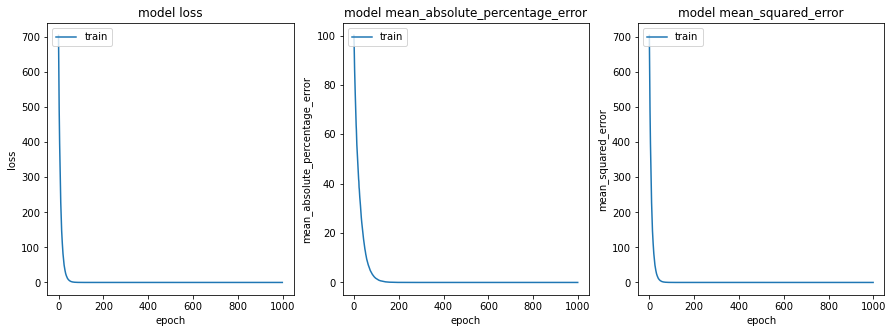

In [54]:
# "Loss"
fig, axs = plt.subplots(1, 3, figsize=(15,5))
axs[0].plot(history.history['loss'])
axs[0].set_title('model loss')
axs[0].set_ylabel('loss')
axs[0].set_xlabel('epoch')
axs[0].legend(['train'], loc='upper left')


for i, metric in enumerate(set(history.history.keys()).difference(["loss"])):
    axs[i + 1].plot(history.history[metric])
    axs[i + 1].set_title(f'model {metric}')
    axs[i + 1].set_ylabel(f'{metric}')
    axs[i + 1].set_xlabel('epoch')
    axs[i + 1].legend(['train'], loc='upper left')


plt.show()

In [55]:
print(model.summary())

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_124 (Dense)            (None, 1)                 3         
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________
None


### Adapting the code to become a logistic regression

In [56]:
x_train, x_test, y_train, y_test = train_test_split(*make_classification(n_features=5))
print("Training features: \n", x_train[:5])
print("Training labels: \n", y_train[:5])

Training features: 
 [[ 1.51765341  0.5011218  -0.94751542  0.5348701   1.18145051]
 [-3.12731209 -0.53041866  1.66278592 -1.1184367  -1.60828604]
 [-0.89171473 -0.769031   -0.03999149  0.42966724 -1.00303873]
 [ 1.27652093  0.77699375  1.65969014 -1.78940885  0.13549749]
 [ 0.04683443  0.53561014 -2.77958078  2.05048599  2.2206959 ]]
Training labels: 
 [0 0 1 0 1]


In [57]:
model = Sequential()
model.add(layers.Dense(1, activation="sigmoid"))

In [58]:
model.compile(optimizers.SGD(), loss=losses.binary_crossentropy,
              metrics=["accuracy", metrics.AUC()])
model.build(input_shape=(None, 5))
model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_125 (Dense)            (None, 1)                 6         
Total params: 6
Trainable params: 6
Non-trainable params: 0
_________________________________________________________________


In [59]:
history = model.fit(x_train, y_train, epochs=1000, verbose=0, batch_size=len(x_train))

In [60]:
predictions = model.predict(x_train)

First 5 predictions: 
 [[0.80600786 0.0265024  0.6386635  0.01293716 0.9929013 ]]
Available logs:  loss, accuracy, auc
1


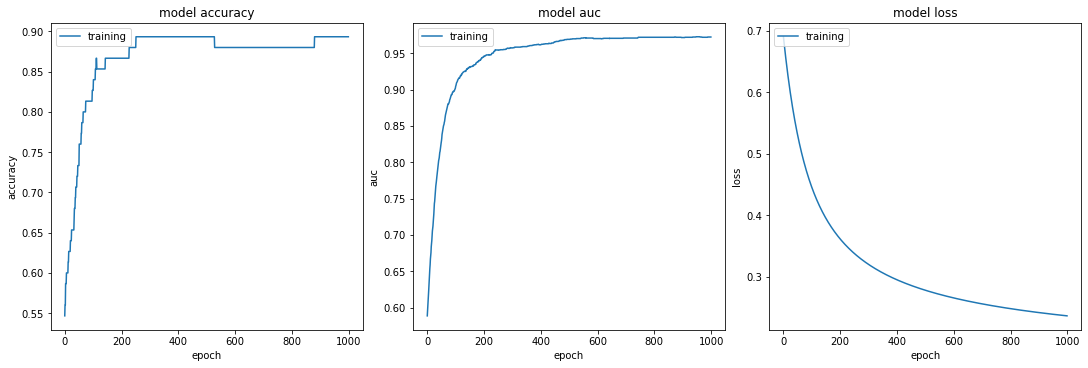

In [61]:
def plot_history(training_history):
    logs_available = training_history.history.keys()
    print("First 5 predictions: \n", predictions[:5].transpose())
    print("Available logs: ", ", ".join(training_history.history.keys()))
    fig, axs = plt.subplots(len(logs_available) // 3, 3, figsize=(15,5), constrained_layout=True)
    if len(axs.shape) < 2:
        axs = axs.reshape(1, axs.shape[0])
    print(1 + len(logs_available) % 3)
    for i, metric in enumerate(set(training_history.history.keys())):
        axs[i // 3, i % 3].plot(history.history[metric])
        axs[i // 3, i % 3].set_title(f'model {metric}')
        axs[i // 3, i % 3].set_ylabel(f'{metric}')
        axs[i // 3, i % 3].set_xlabel('epoch')
        if "val_" in metric:
            axs[i // 3, i % 3].legend(['validation'], loc='upper left')
        else:
            axs[i // 3, i % 3].legend(['training'], loc='upper left')


    plt.show()

plot_history(history)

## From linear models to non-linear models: the Multi-Layer perceptron
### What was going on with the linear models?

Hidden layers are the layers between the input layer and the output layer. There are a number of possible layers we could add, the most common being a "dense" layer, which means every of its "neurons" are connected to the previous layer, and to the next layer.

In the linear case, with $x_1, \dots, x_n$ being the $n$ variables with $m$ realisations, i.e. there are $n$ features for which we have $m$ samples, we calculate the coefficients $a_1, \dots, a_n$ and the bias $b$ ($b, \dots, b$ (only one value) so that the loss function (e.g. mean squared error, $\sum_{i=1}^{m}(a x_i + b - y_i)^2$) is minimum (in this notation, $a$ and $x_i$ are $n$ dimentional vectors). In matrix form, once the coefficients are learned, the model looks like this:

$$y =\begin{bmatrix}
x_{1, 1}  \dots x_{1,n}\\
\vdots \\
x_{m, 1}  \dots x_{m,n}
\end{bmatrix}
\begin{bmatrix}
a_{1} \\
a_{2} \\
\vdots \\
a_{n}
\end{bmatrix}
+ b
$$

The associated code for this was:
```python
model = Sequential()
model.add(layers.Dense(1))
```

The Dense layer has "1" neuron because each $$y$$ value is a real number. If y was a vector, e.g. of dimension 2, we would be predicting two real numbers (e.g. [1., 2.]), and the number of neurons would be 2 in the Dense layer.

In the binary classification case, the model looks almost the same, only a sigmoid is applied (or softmax when multi-class):

$$y = sigmoid(
          \begin{bmatrix}
           x_{1, 1}  \dots x_{1,n}\\
           \vdots \\
           x_{m, 1}  \dots x_{m,n}
          \end{bmatrix}
          \begin{bmatrix}
           a_{1} \\
           a_{2} \\
           \vdots \\
           a_{n}
         \end{bmatrix}
         + b
         )
$$

Associated code:

```python
model = Sequential()
model.add(layers.Dense(1, activation="sigmoid"))
```

Again, he Dense layer has "1" neuron because each $$y$$ value is a real number. If y was a vector, e.g. of dimension 3, we would change the activation for softmax, use CategoricalCrossentropy as a loss function and the model would be:


```python
model = Sequential()
model.add(layers.Dense(3, activation="softmax"))
```

Notice that the softmax function will make all $y$ values add up to one, and be between 0 and 1, making them interpretable as a probability. To get a class prediction, you would take the argmax of the prediction.

### Capturing non-linear relationships - step one: add a "hidden layer"
A "hidden layer" is a layer that is neither an input or an output layer. The above models do not need to specify the input layer as it is always the raw input data, but the output layer was provided as a Dense layer with as many neurons as there are values to predict.

Hence, to add a hidden layer, you would do the following:


In [62]:
hyperparameter_number_of_neurons = 4
model = Sequential()
model.add(layers.Dense(hyperparameter_number_of_neurons))
model.add(layers.Dense(2))

The number of neurons is a hyperparameter to be chosen by the user.

![Neural network with one hidden layer with 4 neurons](/assets/images/neural_network_one_hidden_layer.jpg)

There are a number of possible layers we could add, the most common being a "dense" layer, which means every of its "neurons" are connected to the previous layer, and to the next layer (just like in the above figure).

Adding a dense layer with 4 neurons and without an activation function looks like this:
$$y = \begin{bmatrix}
x_{1, 1} \dots x_{1,n}\\
\vdots \\
x_{m, 1} \dots x_{m,n}
\end{bmatrix}
\begin{bmatrix}
h_{1,1}  \dots h_{1, 4}\\
\vdots\\
h_{n, 1}  \dots h_{n, 4}
\end{bmatrix}
\begin{bmatrix}
a'_{1}\\
a'_{2}\\
a'_{3}\\
a'_{4} \end{bmatrix} + b$$

**Here, the matrix $\begin{bmatrix}
h_{1,1}  \dots h_{1, 4}\\
\vdots \\
h_{n, 1}  \dots h_{n, 4}
\end{bmatrix}$ is of dimension $n$ by 4 (caveat! not $m$ by 4).** We multiply each feature by h1, then each feature by h2, etc.

Notice that the $a$ vector now only has 4 coefficients, because there are only 4 connections between the hidden layer and the output. Once the weights are learned, this is equivalent to a linear model:
$$\begin{bmatrix} 
a_{1} \\
a_{2} \\
\vdots \\
a_{n}
\end{bmatrix} = \begin{bmatrix}
h_{1,1}  \dots h_{1, 4}\\
\vdots \\
h_{n, 1}  \dots h_{n, 4}
\end{bmatrix}
\begin{bmatrix}
a'_{1} \\
a'_{2} \\
a'_{3} \\
a'_{4}
\end{bmatrix}
= \begin{bmatrix}
h_{1,1} a'_1 + \dots + h_{1,4} a'_1 \\
\vdots \\
h_{n,1} a'_4 + \dots + h_{n,4} a'_4 \\
\end{bmatrix}
$$

Although this is equivalent for prediction, the coefficients are learned differently, and results might differ.

### Step two: capture more complex features by adding non-linearity
The most common function is the Rectifier Linear Unit, or ReLU:
$$Relu(z) = max(0, z) $$

Previously, we have used the sigmoid activation function for binary classification, and softmax for multi-class classification. Their formulas are the following:

**Sigmoid**

$$\sigma(z) = \frac{1} {1 + e^{-z}} = \frac{e^z} {1 + e^{z}} $$

**Softmax**

$$\sigma(z_i) = \frac{e^{z_{i}}}{\sum_{j=1}^K e^{z_{j}}} \ \ \ for\ i=1,2,\dots,K$$

Notice the softmax and sigmoid are essentially the same and that the softmax is the generalization of the sigmoid to a vector. In other words, when using a sigmoid, $z$ is a real number, and when using a softmax, $z$ is a $K$ dimensional vector and the formula is given for $z_i$. We'll look into this in a future notebook on activation functions.

Notice that if you sum over $$i$$, the result is 1: $$\sum_{i=1}^{K} \sigma(z_i) =  \sum_{i=1}^{K} \frac{e^{z_{i}}}{\sum_{j=1}^K e^{z_{j}}} =  \frac{\sum_{i=1}^{K} e^{z_{i}}}{\sum_{j=1}^K e^{z_{j}}} = 1$$ .

Let's have a look at what the sigmoid and ReLU functions look like:

#### ReLU


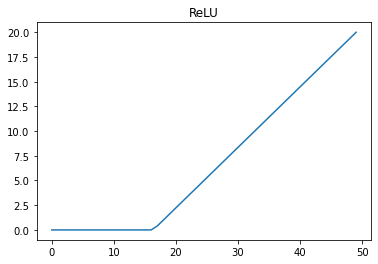

In [63]:
z = np.linspace(-10, 20)
plt.title("ReLU")
plt.plot(np.maximum(z, 0))

#### Sigmoid

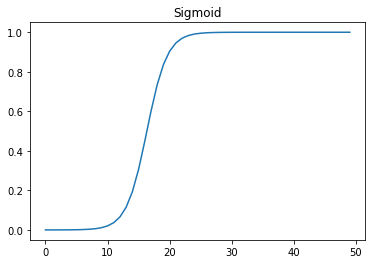

In [64]:
z = np.linspace(-10, 20)
z = 1/(1 + np.exp(-z))
plt.title("Sigmoid")
plt.plot(z)

### Softmax (activation function)

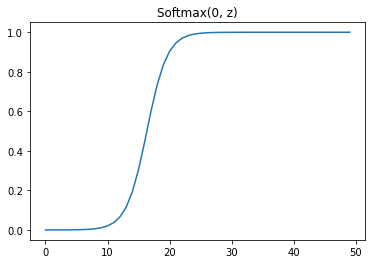

In [65]:
z = np.linspace(-10, 20)
z = np.exp(z)/(1 + np.exp(z))
plt.title("Softmax(0, z)")
plt.plot(z)

#### What does the denominator of the softmax function look like?

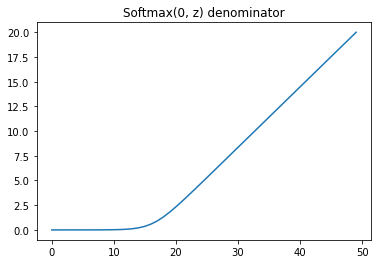

In [66]:
z = np.linspace(-10, 20)
z = np.log(1 + np.exp(z))
plt.title("Softmax(0, z) denominator")
plt.plot(z)

Almost like a ReLU, right? That's because that denominator approximates the max function, and in the case where we're approximating $max(0, z)$, then we're approximating a ReLU function.
The softmax function is also called soft-argmax, because it approximates the argmax function: which $i$ in $z = (z_1, \dots, z_n) $ relates to the highest value? That's why it is so useful in classification problems, where $z$ is the vector of possible outcomes, and we calculate a number that can be interpreted as a probability for each class to determine the most likely.


#### What does the matrix multiplication we had before become when we add an activation function f?
It looks almost the same, except that you apply the function in the hidden layer:

$$ y = f \left ( \begin{bmatrix}
x_{1, 1}  \dots x_{1,n}\\
\vdots \\
x_{m, 1}  \dots x_{m,n}
\end{bmatrix}
\begin{bmatrix}
h_{1,1}  \dots h_{1, 4}\\
\vdots \\
h_{n, 1}  \dots h_{n, 4}
\end{bmatrix} \right)
\begin{bmatrix}
a'_{1} \\
a'_{2} \\
a'_{3} \\
a'_{4} \end{bmatrix}
+ b
$$

Which, if we perform the matrix multiplication, gives us:

$$
y = f \left (  \begin{bmatrix}
            \sum_{i=1}^n x_{1,i} h_{i, 1}  \dots  \sum_{i=1}^n x_{1,i} h_{i, 4}\\
           \vdots \\
          \sum_{i=1}^n x_{m,i} h_{i, 1}  \dots  \sum_{i=1}^n x_{m,i} h_{i, 4}
          \end{bmatrix}  \right)
 \begin{bmatrix}
           a'_{1} \\
           a'_{2} \\
           a'_{3} \\
           a'_{4}
         \end{bmatrix}
         + b
$$

$$
y = \begin{bmatrix}
            f\left(\sum_{i=1}^n x_{1,i} h_{i, 1} \right)  \dots  f\left(\sum_{i=1}^n x_{1,i} h_{i, 4}\right)\\
           \vdots \\
          f\left(\sum_{i=1}^n x_{m,i} h_{i, 1}\right)  \dots   f\left(\sum_{i=1}^n x_{m,i} h_{i, 4}\right)
          \end{bmatrix}
 \begin{bmatrix}
           a'_{1} \\
           a'_{2} \\
           a'_{3} \\
           a'_{4}
         \end{bmatrix}
         + b
$$


### Using Keras, adding a hidden layer is as simple as using the add method once more and specifying the function's name:

In [67]:
N_FEATURES = 2
x_train, x_test, y_train, y_test = train_test_split(*make_regression(n_features=N_FEATURES, n_samples=100000))
print("Training features: \n", x_train[:5])
print("Training labels: \n", y_train[:5])

Training features: 
 [[-0.60976829  0.11308318]
 [-0.76085854 -1.36071621]
 [-0.25549485 -0.28396875]
 [-1.27601354 -0.37409726]
 [ 0.16795124 -0.4998333 ]]
Training labels: 
 [ -7.4705109  -16.98478549  -4.82092462 -18.74930179  -0.33388962]


In [68]:
hyperparameter_number_of_neurons = 1
hyperparameter_non_linear_function = "relu"
model = Sequential()
model.add(layers.Dense(hyperparameter_number_of_neurons, activation=hyperparameter_non_linear_function))
model.add(layers.Dense(1))

In [69]:
model.compile(optimizers.SGD(), loss=losses.MeanSquaredError(),
              metrics=[metrics.MeanSquaredError(), metrics.MeanAbsolutePercentageError()])
model.build(input_shape=(None, N_FEATURES))
model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_128 (Dense)            (None, 1)                 3         
_________________________________________________________________
dense_129 (Dense)            (None, 1)                 2         
Total params: 5
Trainable params: 5
Non-trainable params: 0
_________________________________________________________________


In [70]:
history = model.fit(x_train, y_train, epochs=375, batch_size=len(x_train), validation_data=(x_test, y_test), verbose=0)

First 5 predictions: 
 [[0.80600786 0.0265024  0.6386635  0.01293716 0.9929013 ]]
Available logs:  loss, mean_squared_error, mean_absolute_percentage_error, val_loss, val_mean_squared_error, val_mean_absolute_percentage_error
1


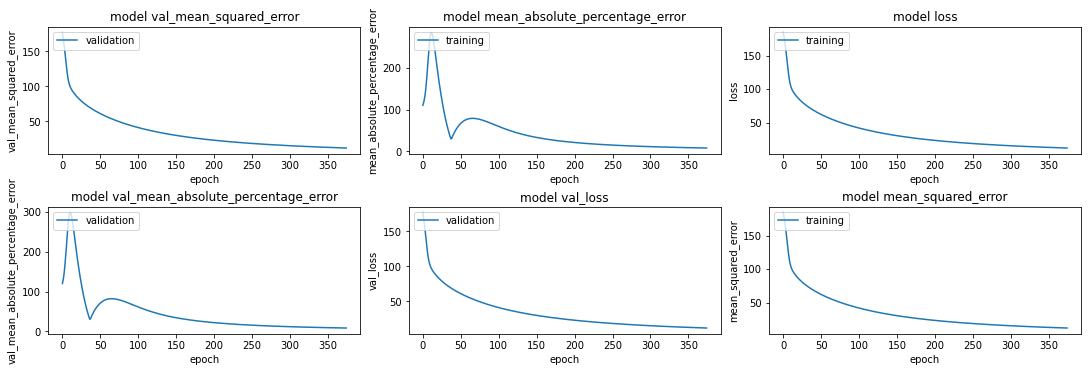

In [71]:
plot_history(history)

This network is training pretty well, as shown above. But how does it compare with the linear model?

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_130 (Dense)            (None, 1)                 3         
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________
None
First 5 predictions: 
 [[0.80600786 0.0265024  0.6386635  0.01293716 0.9929013 ]]
Available logs:  loss, mean_squared_error, mean_absolute_percentage_error, val_loss, val_mean_squared_error, val_mean_absolute_percentage_error
1


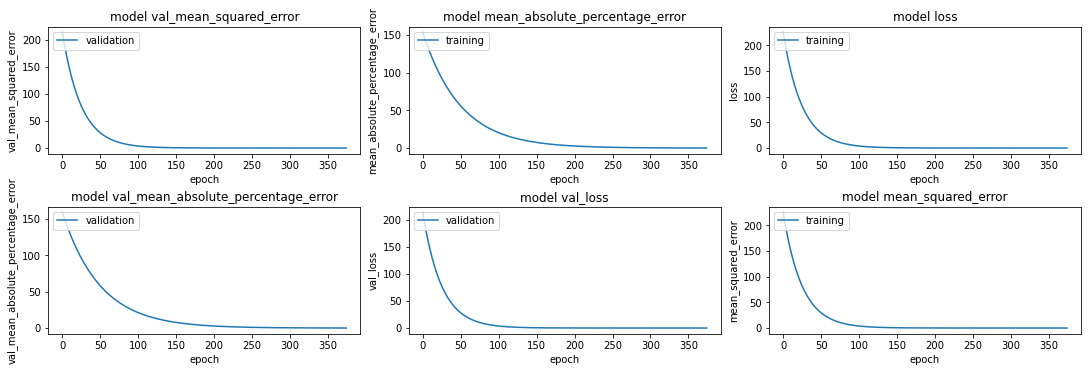

In [72]:
hyperparameter_number_of_neurons = 1
hyperparameter_non_linear_function = "relu"
model = Sequential()
model.add(layers.Dense(1))
model.compile(optimizers.SGD(), loss=losses.MeanSquaredError(),
              metrics=[metrics.MeanSquaredError(), metrics.MeanAbsolutePercentageError()])
model.build(input_shape=(None, N_FEATURES))
print(model.summary())
history = model.fit(x_train, y_train, epochs=375, batch_size=len(x_train), validation_data=(x_test, y_test), verbose=0)

plot_history(history)

The linear model learned much better, with less overfitting, needing fewer epochs. The non linear model had a loss 72, when this model is roughly 0.

### How can we improve the non-linear model?

#### Tuning hyperparameters with the keras tuner

There are many hyperparameters that can be tuned. Arguably the two most important to try would be the number of neurons in the hidden layer, and the optimization algorithm. We can do this using the keras tuner: it will try different combinations of parameters and record the best one. Coupled with early stopping, this becomes a very powerful tool: you do not need to wait for the full training of a model to sort promising sets of parameters from non-promising ones.

In [73]:
import keras_tuner as kt

def build_model(hp):
    model = Sequential()
    model.add(layers.Dense(
        hp.Choice('units', [1, 16, 32, 64, 128]),
        activation='relu'))
    model.add(layers.Dense(1))
    model.compile(hp.Choice("optimizer", ["rmsprop", "adam", "sgd"]),
                  loss='mean_squared_error',
                  metrics=[metrics.MeanSquaredError(), metrics.MeanAbsolutePercentageError()])
    return model

tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=50,
    overwrite=True)

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
tuner.search(x_train, y_train, epochs=15, validation_data=(x_test, y_test), callbacks=[stop_early], batch_size=len(x_train), verbose=0)

INFO:tensorflow:Oracle triggered exit


In [74]:
best_hyperparameters = tuner.get_best_hyperparameters()[0]
print("Best optimizer: ", best_hyperparameters.get("optimizer"))
print("Best number of neurons in the hidden layer: ", best_hyperparameters.get("units"))

Best optimizer:  sgd
Best number of neurons in the hidden layer:  32


Here we can see that Stochastic Gradient Descent was the best optimization algorithm, and that the highest number of neurons in the hidden layer yielded the best results. Lets train a model using these parameters:

In [75]:
model = Sequential()
model.add(layers.Dense( best_hyperparameters.get("units"), activation='relu'))
model.add(layers.Dense(1))
model.compile(
    optimizer=best_hyperparameters.get("optimizer"),
    loss='mean_squared_error',
    metrics=[metrics.MeanSquaredError(), metrics.MeanAbsolutePercentageError()])
model.build(input_shape=(None, N_FEATURES))
print(model.summary())
history = model.fit(x_train, y_train, epochs=100, batch_size=len(x_train), validation_data=(x_test, y_test), verbose=0)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 32)                96        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 129
Trainable params: 129
Non-trainable params: 0
_________________________________________________________________
None


Best loss: 1.3412628173828125
First 5 predictions: 
 [[0.80600786 0.0265024  0.6386635  0.01293716 0.9929013 ]]
Available logs:  loss, mean_squared_error, mean_absolute_percentage_error, val_loss, val_mean_squared_error, val_mean_absolute_percentage_error
1


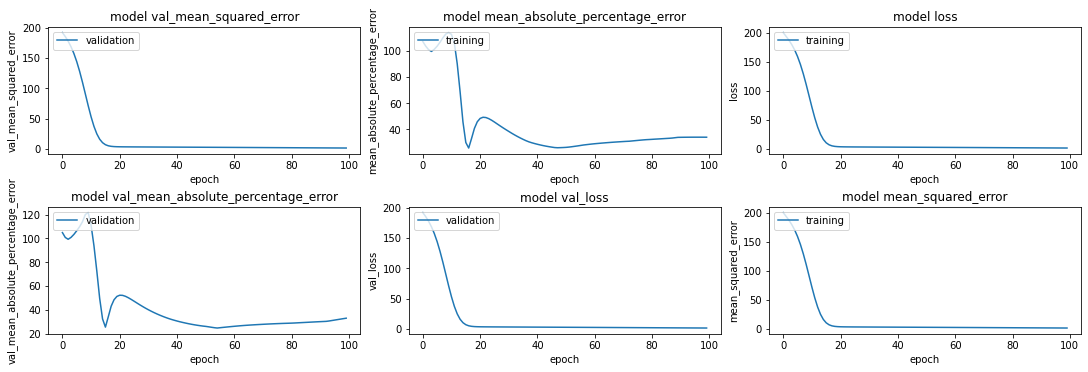

In [76]:
print("Best loss:", np.min(history.history['loss']))
plot_history(history)

The best loss is now much better, comparable to the linear model!

#### The effect of increasing the number of neurons in the hidden layer

In [77]:
values_to_test = [1, 16, 32, 64, 128, 256]
training_loss = list()
test_loss = list()


for n_units in tqdm.tqdm(values_to_test, total=len(values_to_test)):
    model = Sequential()
    model.add(layers.Dense(n_units, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(
        optimizer=best_hyperparameters.get("optimizer"),
        loss='mean_squared_error',
        metrics=[metrics.MeanSquaredError(), metrics.MeanAbsolutePercentageError()])
    model.build(input_shape=(None, N_FEATURES))
    history = model.fit(x_train, y_train, epochs=100, batch_size=len(x_train), validation_data=(x_test, y_test), verbose=0)
    training_loss.append(np.min(history.history['loss']))
    test_loss.append(np.min(history.history['val_loss']))


100%|██████████| 6/6 [00:54<00:00,  9.14s/it]


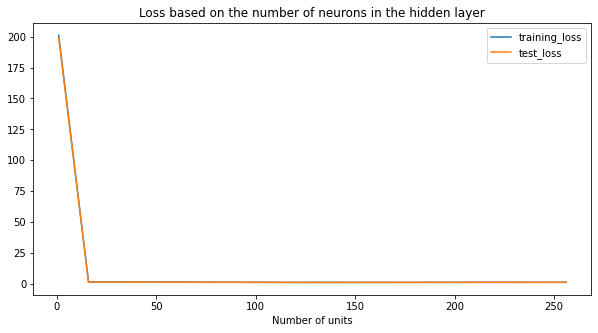

In [78]:
plt.figure(figsize=(10, 5))
plt.plot(values_to_test, training_loss)
plt.plot(values_to_test, test_loss)
plt.legend(["training_loss", "test_loss"])
plt.xlabel("Number of units")
plt.title("Loss based on the number of neurons in the hidden layer")
plt.show()

It looks like increasing the number of neurons improves performance. Lets confirm this by zooming in the right part of the graph:

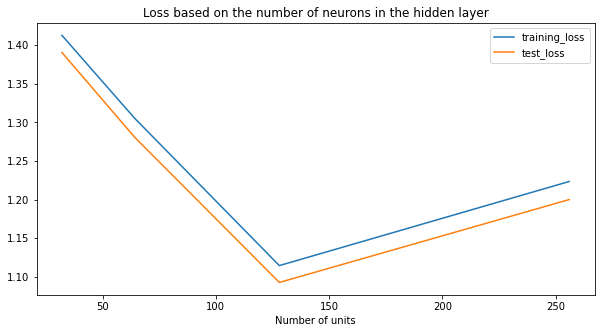

In [79]:
plt.figure(figsize=(10, 5))
plt.plot(values_to_test[2:], training_loss[2:])
plt.plot(values_to_test[2:], test_loss[2:])
plt.legend(["training_loss", "test_loss"])
plt.xlabel("Number of units")
plt.title("Loss based on the number of neurons in the hidden layer")
plt.show()

As we increase the number of neurons in the hidden layer, we capture more complex relationships between input variables and the model improves. However, the model becomes more complex, and more data or at least more passes through it are required. For example, increasing the number of epochs will improve results:

In [80]:
model = Sequential()
model.add(layers.Dense(values_to_test[-1], activation='relu'))
model.add(layers.Dense(1))
model.compile(
    optimizer=best_hyperparameters.get("optimizer"),
    loss='mean_squared_error',
    metrics=[metrics.MeanSquaredError(), metrics.MeanAbsolutePercentageError()])
model.build(input_shape=(None, N_FEATURES))
history = model.fit(x_train, y_train, epochs=500, batch_size=len(x_train), validation_data=(x_test, y_test), verbose=0)

In [81]:
print("Best loss:", np.min(history.history['loss']))
print("Test loss:", np.min(history.history['val_loss']))

Best loss: 0.0005870321183465421
Test loss: 0.0005787759437225759


Results are dramatically better here.
However, this is a very simple dataset, that a linear model was able to fit very well. Was going through this whole parameter search worth it? We'll leave it up to you to decide. However, linear models do come with their limitations: they can only model linear relationships, while the last model we build was much more powerful.

### Linear vs non linear: non linear data

Lets simulate a non-linear process:

Text(0.5, 1.0, 'Non linear data')

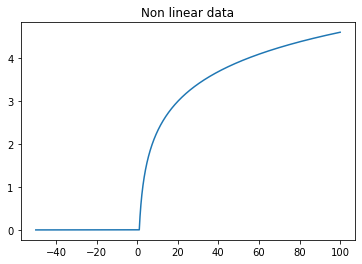

In [82]:
x = np.linspace(-50, 100, num=20000)
y = np.log(np.maximum(x, 1))

plt.plot(x, y)
plt.title("Non linear data")

In [83]:
def build(linear: bool) -> Sequential:
    model = Sequential()
    if not linear:
        model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(
        optimizer="adam",
        loss='mean_squared_error',
        metrics=[metrics.MeanSquaredError(), metrics.MeanAbsolutePercentageError()])
    model.build(input_shape=(None, 1))
    return model


In [84]:
linear_model = build(linear=True)
non_linear_model = build(linear=False)
history_linear = linear_model.fit(x, y, epochs=500, batch_size=len(x), verbose=0)
history_non_linear = non_linear_model.fit(x, y, epochs=500, batch_size=len(x), verbose=0)

Best loss with the linear model: 111.97464752197266 Best loss with the NON - linear model: 0.02975444123148918
Available logs:  loss, mean_squared_error, mean_absolute_percentage_error


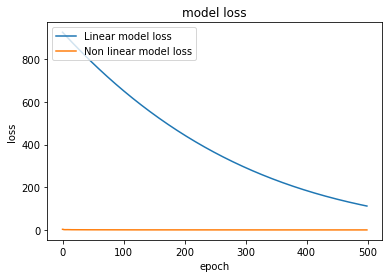

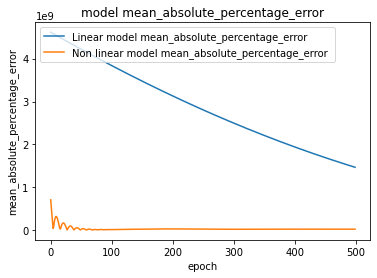

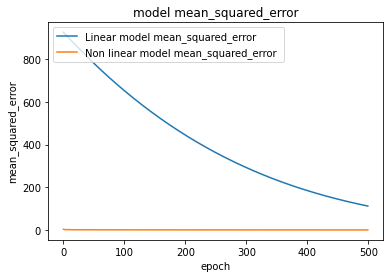

In [85]:
print("Best loss with the linear model:", np.min(history_linear.history['loss']),
      "Best loss with the NON - linear model:", np.min(history_non_linear.history['loss']))
print("Available logs: ", ", ".join(history_linear.history.keys()))
# "Loss"
plt.plot(history_linear.history['loss'])
plt.plot(history_non_linear.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Linear model loss', "Non linear model loss"], loc='upper left')
plt.show()

for metric in set(history_linear.history.keys()).difference(["loss"]):
    plt.plot(history_linear.history[metric])
    plt.plot(history_non_linear.history[metric])
    plt.title(f'model {metric}')
    plt.ylabel(f'{metric}')
    plt.xlabel('epoch')
    plt.legend([f"Linear model {metric}", f"Non linear model {metric} "], loc='upper left')
    plt.show()

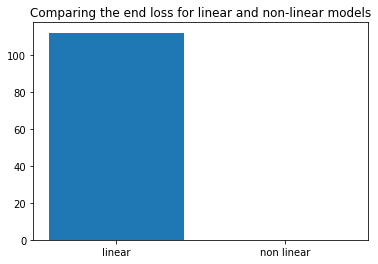

In [86]:
min_loss_linear = np.min(history_linear.history['loss'])
min_loss_non_linear = np.min(history_non_linear.history['loss'])
plt.bar(["linear", "non linear"], [min_loss_linear, min_loss_non_linear])
plt.title("Comparing the end loss for linear and non-linear models")
plt.show()

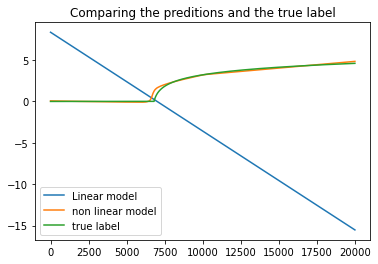

In [87]:
plt.plot(linear_model.predict(x))
plt.plot(non_linear_model.predict(x))
plt.plot(y)
plt.legend(["Linear model", "non linear model", "true label"])
plt.title("Comparing the preditions and the true label")
plt.show()

We can see that the non-linear model clearly fits the data better. It could certainly be optimized for a better performance, while the linear model never had a change to fit correctly to this data.

## Beware vanishing gradients
ToDo show that too many hidden layers kills the learning. More on this on a backprop notebook. + show it takes longer to define and train.
Show a high level idea of how backprop works in this case.

**!!Make sure batch size is set to something that fits in memory!!**

In [97]:
model = Sequential()
for i in range(100):
    model.add(layers.Dense(64, activation="relu"))
model.add(layers.Dense(1))
model.compile(
    optimizer="sgd",
    loss='mean_squared_error',
    metrics=[metrics.MeanSquaredError(), metrics.MeanAbsolutePercentageError()])
model.build(input_shape=(None, N_FEATURES))

In [98]:
history = model.fit(x_train, y_train, batch_size=len(x_train)//4, validation_data=(x_test, y_test), epochs=30, verbose=2)

Epoch 1/30
4/4 - 9s - loss: 201.0601 - mean_squared_error: 201.0601 - mean_absolute_percentage_error: 100.0237 - val_loss: 199.3598 - val_mean_squared_error: 199.3598 - val_mean_absolute_percentage_error: 100.0922
Epoch 2/30
4/4 - 4s - loss: 201.0598 - mean_squared_error: 201.0598 - mean_absolute_percentage_error: 100.1583 - val_loss: 199.3594 - val_mean_squared_error: 199.3594 - val_mean_absolute_percentage_error: 100.2456
Epoch 3/30
4/4 - 4s - loss: 201.0600 - mean_squared_error: 201.0600 - mean_absolute_percentage_error: 100.1407 - val_loss: 199.3591 - val_mean_squared_error: 199.3591 - val_mean_absolute_percentage_error: 100.3962
Epoch 4/30
4/4 - 3s - loss: 201.0597 - mean_squared_error: 201.0597 - mean_absolute_percentage_error: 100.3403 - val_loss: 199.3588 - val_mean_squared_error: 199.3588 - val_mean_absolute_percentage_error: 100.5263
Epoch 5/30
4/4 - 2s - loss: 201.0596 - mean_squared_error: 201.0596 - mean_absolute_percentage_error: 100.5673 - val_loss: 199.3586 - val_mean_s

Best loss: 201.059326171875
Available logs:  loss, mean_squared_error, mean_absolute_percentage_error, val_loss, val_mean_squared_error, val_mean_absolute_percentage_error
First 5 predictions: 
 [[0.80600786 0.0265024  0.6386635  0.01293716 0.9929013 ]]
Available logs:  loss, mean_squared_error, mean_absolute_percentage_error, val_loss, val_mean_squared_error, val_mean_absolute_percentage_error
1


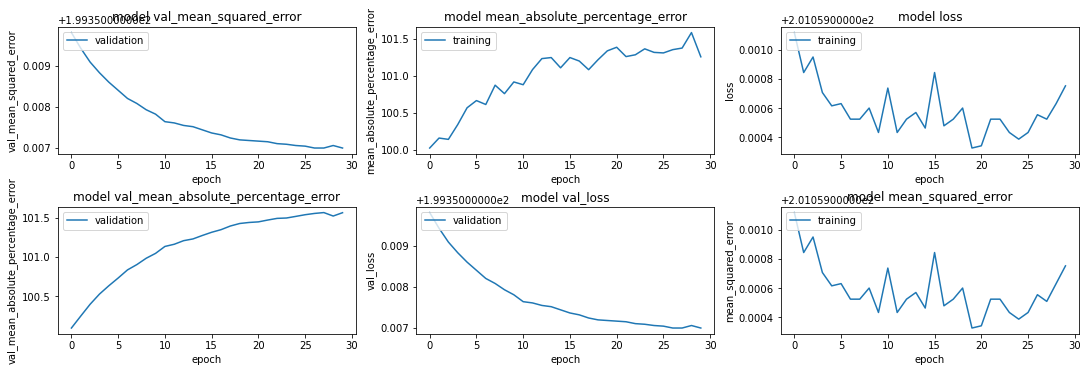

In [99]:
print("Best loss:", np.min(history.history['loss']))
print("Available logs: ", ", ".join(history.history.keys()))
plot_history(history)

What we see here is the model's loss not changing. This is due to gradients becoming smaller and smaller in each hidden layer, and eventually becoming so small they are essentially 0: they "vanish". As the weight updates are proportional to the gradient values, they end up not changing, hence the model is not learning. If we remove all these hidden layers, the model learns again:

In [100]:
model = Sequential()
model.add(layers.Dense(64, activation="relu"))
model.add(layers.Dense(1))
model.compile(
    optimizer="sgd",
    loss='mean_squared_error',
    metrics=[metrics.MeanSquaredError(), metrics.MeanAbsolutePercentageError()])
model.build(input_shape=(None, N_FEATURES))
history = model.fit(x_train, y_train, batch_size=len(x_train), validation_data=(x_test, y_test), epochs=30, verbose=2)

Epoch 1/30
1/1 - 0s - loss: 202.3768 - mean_squared_error: 202.3768 - mean_absolute_percentage_error: 108.4286 - val_loss: 190.8527 - val_mean_squared_error: 190.8527 - val_mean_absolute_percentage_error: 105.5714
Epoch 2/30
1/1 - 0s - loss: 192.4807 - mean_squared_error: 192.4807 - mean_absolute_percentage_error: 104.4175 - val_loss: 181.2253 - val_mean_squared_error: 181.2253 - val_mean_absolute_percentage_error: 101.7004
Epoch 3/30
1/1 - 0s - loss: 182.7805 - mean_squared_error: 182.7805 - mean_absolute_percentage_error: 102.0772 - val_loss: 170.6367 - val_mean_squared_error: 170.6367 - val_mean_absolute_percentage_error: 98.1805
Epoch 4/30
1/1 - 0s - loss: 172.1147 - mean_squared_error: 172.1147 - mean_absolute_percentage_error: 100.0218 - val_loss: 158.2995 - val_mean_squared_error: 158.2995 - val_mean_absolute_percentage_error: 94.4430
Epoch 5/30
1/1 - 0s - loss: 159.6872 - mean_squared_error: 159.6872 - mean_absolute_percentage_error: 97.6292 - val_loss: 143.6936 - val_mean_squa

Best loss: 3.071847915649414
Available logs:  loss, mean_squared_error, mean_absolute_percentage_error, val_loss, val_mean_squared_error, val_mean_absolute_percentage_error
First 5 predictions: 
 [[0.80600786 0.0265024  0.6386635  0.01293716 0.9929013 ]]
Available logs:  loss, mean_squared_error, mean_absolute_percentage_error, val_loss, val_mean_squared_error, val_mean_absolute_percentage_error
1


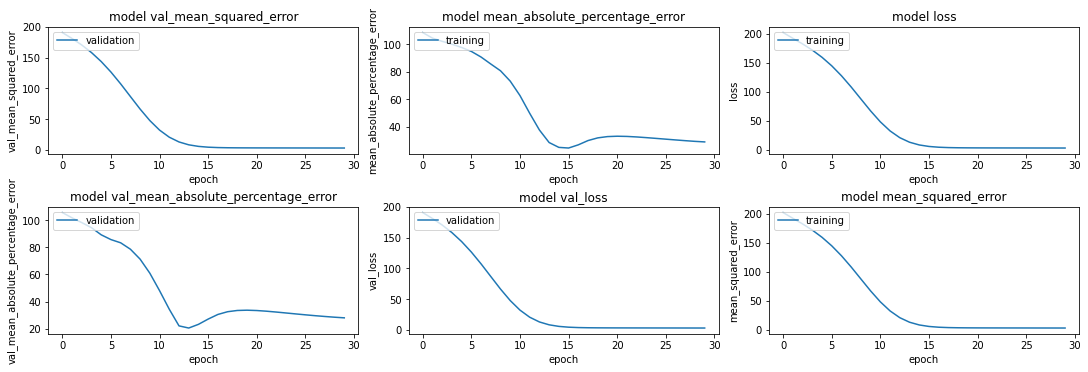

In [101]:
print("Best loss:", np.min(history.history['loss']))
print("Available logs: ", ", ".join(history.history.keys()))
# "Loss"
plot_history(history)

This is a common problem in deep learning. Here the solution is simple: when the loss doesn't improve, reduce the number of hidden layers. However, there are ways to get arround it. In computer vision, the Residual Net architecture connects the output of a block of layers with the output of the previous block of layers, so that if the gradient vanishes, the non useful layers are bypassed.